In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np

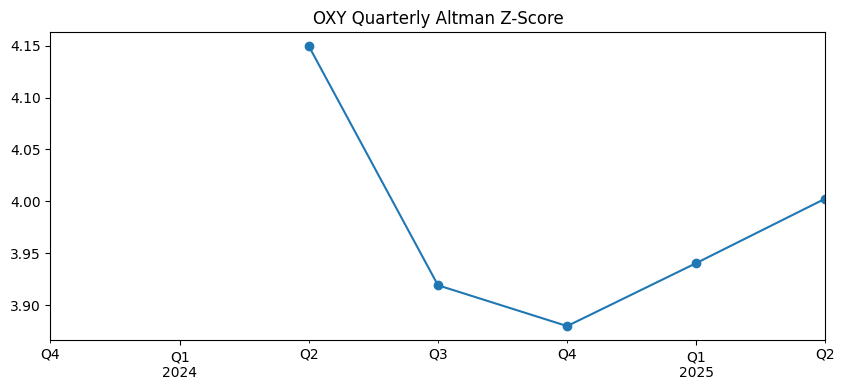

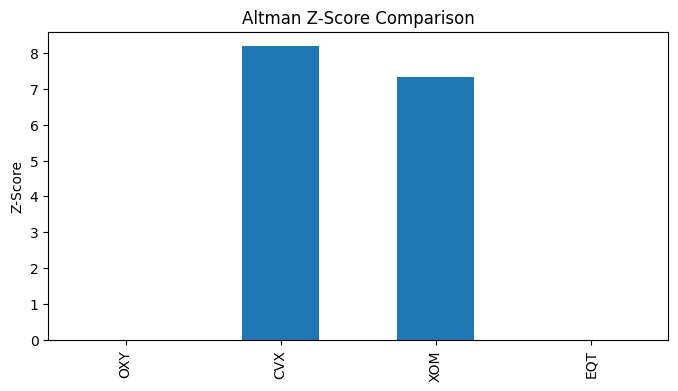

OXY DSCR: nan


In [7]:
# Helper: Find financial line by keyword
def find_line(df: pd.DataFrame, keywords: list) -> pd.Series:
    """
    Search df.columns for any label containing one of the keywords.
    Return the first match’s column as a Series.
    """
    for kw in keywords:
        matches = [lbl for lbl in df.columns if kw.lower() in lbl.lower()]
        if matches:
            return df[matches[0]]
    return pd.Series(index=df.index, data=np.nan)

# Compute Altman Z-Score from quarterly data
def compute_z_score_q(bs: pd.DataFrame, inc: pd.DataFrame, info: dict) -> pd.Series:
    A = (find_line(bs, ["Current Assets"]) - find_line(bs, ["Current Liabilities"])) / find_line(bs, ["Total Assets"])
    B = find_line(bs, ["Retained Earnings"]) / find_line(bs, ["Total Assets"])
    C = find_line(inc, ["EBIT", "Operating Income"]) / find_line(bs, ["Total Assets"])
    liabilities = find_line(bs, ["Total Liabilities"])
    market_cap = info.get("marketCap", np.nan)
    D = market_cap / liabilities
    Z = 6.56 * A + 3.26 * B + 6.72 * C + 1.05 * D
    return Z

# Compute DSCR from annual data
def compute_dscr(ticker: str) -> float:
    t = yf.Ticker(ticker)
    cf = t.cashflow.transpose()
    inc = t.financials.transpose()
    ocf = find_line(cf, ["Operating Cash Flow"])
    interest = find_line(inc, ["Interest Expense"])
    if interest.iloc[-1] == 0 or np.isnan(interest.iloc[-1]):
        return np.nan
    return ocf.iloc[-1] / interest.iloc[-1]

# Get latest Z-Score for peer comparison
def get_latest_z_score(ticker: str) -> float:
    t = yf.Ticker(ticker)
    bs = t.balance_sheet.transpose()
    inc = t.financials.transpose()
    info = t.info
    z = compute_z_score_q(bs, inc, info)
    return z.iloc[-1] if not z.empty else np.nan

# Step 1: OXY quarterly Z-Score trend
oxy = yf.Ticker("OXY")
bs_q = oxy.quarterly_balance_sheet.transpose()
inc_q = oxy.quarterly_financials.transpose()
info = oxy.info

z_scores_q = compute_z_score_q(bs_q, inc_q, info)
z_scores_q.plot(title="OXY Quarterly Altman Z-Score", figsize=(10,4), marker='o')
plt.show()

# Step 2: Peer Z-Score comparison
peers = ["OXY", "CVX", "XOM", "EQT"]
peer_scores = {sym: get_latest_z_score(sym) for sym in peers}
pd.Series(peer_scores).plot(kind="bar", title="Altman Z-Score Comparison", ylabel="Z-Score", figsize=(8,4))
plt.show()

# Step 3: DSCR for OXY
dscr_oxy = compute_dscr("OXY")
print(f"OXY DSCR: {dscr_oxy:.2f}")

In [11]:
# Parameters
n_sim = 1000
n_years = 3
oil_base = 80  # starting oil price
mu = 0.05      # expected annual return
sigma = 0.25   # volatility

# Simulate oil price paths
np.random.seed(42)
oil_paths = np.cumprod(1 + np.random.normal(mu/n_years, sigma/np.sqrt(n_years), (n_years, n_sim)), axis=0) * oil_base

# Assume FCF scales linearly with oil price
fcf_base = df["Free Cash Flow"].iloc[-1]
debt = df["Total Debt"].iloc[-1]
market_cap = info["marketCap"]

# Use previously computed A, B, C from Z-Score
z_sim = []
for path in oil_paths.T:
    oil_price = path[-1]
    fcf = fcf_base * (oil_price / oil_base)
    fcf_yield = fcf / market_cap
    D = market_cap / debt
    Z = 6.56*A + 3.26*B + 6.72*C + 1.05*D
    z_sim.append(Z)

# Convert to DataFrame
z_df = pd.DataFrame({
    "Simulated Z-Score": z_sim,
    "Final Oil Price": oil_paths[-1]
})

NameError: name 'df' is not defined